# AHP Basic Modeling
**Preprocess**
- Split 80% train and 20% test
- I drop 4 features with missing values more than 80%
- I use pipeline to preprocess the data, including feature engineering (tho kinda useless for ensemble tree models), impute missing value using new class (None) for categorical data and median value for numeric data
- Yeah, I guess I did overlook for categorical data encoded in int64 data types, but for now, let them be (there's not much difference since not many variables have missing values)
- I use StandardScaler for scaling numeric features (how about RobustScaler?) (I don't have to do it for tree models tho)
- I use OrdinalEncoder for categorical data (better than one hot, less demanding in complexity)

**Modeling**
- As for modeling, I use 4 linear models, 1 neighbour model (what does it called?), and 4 tree models
- In here, we will do basic model with and without feature engineering and compare both of them.
- I use 5-fold cross validation for evaluating the model
- For evaluation metrics, I use MSLE (root mean squared log error) as a main metric (which I make from scratch, cause for some reason the default result in NaN), and RMSE (root mean squared error) as a helper metric to understand the model better
- I guess that's all for today's briefing.



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# selection & preprocess
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_log_error, root_mean_squared_error

# save
import joblib

In [2]:
df = pd.read_csv('../data/train.csv')
df.drop(columns=['Id'], inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Splitting & Preprocess

In [3]:
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

# remove high missing cols
X.drop('PoolQC MiscFeature Alley Fence'.split(), axis=1, errors='ignore')

num_var = X.select_dtypes(include='number').columns
ord_var = X.select_dtypes(include='object').columns

# splitting data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)
display(X_tr, X_te)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1130,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal
1294,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
860,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal
1105,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
413,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
522,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1036,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca
1361,20,RL,124.0,16158,Pave,NaN,IR1,Low,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
802,60,RL,63.0,8199,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2008,WD,Normal
651,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal


In [4]:
# Feature engineering from kaggle's learn
# rooms' spaciousness, outside area, building type x ground area
def feature_eng(df):
  X = df.copy()

  outside = "WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch".split()

  X["Spaciousness"] = (X["1stFlrSF"]+X["2ndFlrSF"])/X["TotRmsAbvGrd"].replace(0, np.nan)
  X["TotalOutsideSF"] = X[outside].sum(axis=1)
  X["PorchTypes"] = X[outside].gt(0).sum(axis=1)
  
  # must use custom transformer: GroupMeanEncoder
  # X["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")

  # it's prone to error, and should use uhm. 
  X3 = pd.get_dummies(X.BldgType, prefix="Bldg", )
  X3 = X3.mul(X.GrLivArea, axis=0)
  
  return pd.concat([X, X3], axis=1)

feature_eng = FunctionTransformer(feature_eng)

In [30]:
# Preprocess for numerical, ordinal, and nominal features
# Well, not really tho. 
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nom_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', num_pipe, num_var),
    ('ord', ord_pipe, ord_var)
    # ('nom', nom_pipe, nom_var)
])


full_pipe = Pipeline([
    # ('eng', feature_eng),
    ('pre', preprocess),
    ('model', LinearRegression())
])

In [31]:
# custom scorer
def rmse_log(yt, yp):
  lt = np.log1p(yt)
  lp = np.log1p(yp)
  return np.sqrt(np.mean((lt-lp)**2))

rmse_log_scorer = make_scorer(rmse_log, greater_is_better=False)

## Modeling
4 tree models, 4 linear models, and 1 KN regressor. 

In [32]:
# Define a list of regression models
basic_models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    KNeighborsRegressor(),
    RandomForestRegressor(random_state=42),
    HistGradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

In [175]:
# Modeling function
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def modeling(models=basic_models, eng=False):
    res = []
    for model in models:
        if eng:
            full_pipe = Pipeline([
                ('eng', feature_eng),
                ('pre', preprocess),
                ('reg', model)
            ])
        else: 
            full_pipe = Pipeline([
                ('pre', preprocess),
                ('reg', model)
            ])
            
        print(model)      
        grid_search = GridSearchCV(estimator=full_pipe, param_grid = {}, cv=kf, 
                                    scoring = {'rmse':'neg_root_mean_squared_error',
                                                'msle2':'neg_root_mean_squared_log_error',
                                                'msle1': rmse_log_scorer}, 
                                    refit = 'msle2', verbose=0, n_jobs=-1)
            
        grid_search.fit(X_tr, y_tr)

        result = {
                'model': type(model).__name__,
                'msle1': -grid_search.cv_results_['mean_test_msle1'][0],
                'rmse': -grid_search.cv_results_['mean_test_rmse'][0],
                'msle2': -grid_search.cv_results_['mean_test_msle2'][0],
                'time': grid_search.cv_results_['mean_fit_time'][0],
                'params': model.get_params()
            }
    
        res.append(result)
        if result['model'] == 'HistGradientBoostingRegressor': grid_basic = grid_search
        
    res = pd.DataFrame(res)
    res.set_index('model', inplace=True)
    return pd.DataFrame(res), grid_basic

In [176]:
# First modeling (51.9s)
res_basic, grid_basic = modeling()

LinearRegression()


Ridge(random_state=42)
Lasso(random_state=42)


c:\Users\ACER\OneDrive\Lepas Kuliah\Projects\house-price-prediction\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


ElasticNet(random_state=42)
KNeighborsRegressor()
RandomForestRegressor(random_state=42)
HistGradientBoostingRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

In [177]:
# Second modeling (39.7s)
res_eng, grid_eng = modeling(eng=True)

LinearRegression()
Ridge(random_state=42)
Lasso(random_state=42)


c:\Users\ACER\OneDrive\Lepas Kuliah\Projects\house-price-prediction\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+09, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


ElasticNet(random_state=42)
KNeighborsRegressor()
RandomForestRegressor(random_state=42)
HistGradientBoostingRegressor(random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

In [181]:
display(res_basic.sort_values('msle1', ascending=True), 
        res_eng.sort_values('msle1', ascending=True))

,msle1,rmse,msle2,time,params
model,,,,,
HistGradientBoostingRegressor,0.134947,28654.379248,0.134947,2.319283,"{'categorical_features': 'from_dtype', 'early_..."
LGBMRegressor,0.135486,28713.579960,0.135486,2.851777,"{'boosting_type': 'gbdt', 'class_weight': None..."
XGBRegressor,0.142372,29872.790625,0.142372,0.738276,"{'objective': 'reg:squarederror', 'base_score'..."
RandomForestRegressor,0.147979,30235.915958,0.147979,4.154044,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
ElasticNet,0.150990,34225.050952,0.150990,0.070462,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
Lasso,0.170916,35253.942977,0.170916,0.142252,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
LinearRegression,0.170961,35257.097741,0.170961,0.061024,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
Ridge,0.171111,35182.378580,0.171111,0.126942,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
KNeighborsRegressor,0.194927,40672.772956,0.194927,0.071596,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."


,msle1,rmse,msle2,time,params
model,,,,,
HistGradientBoostingRegressor,0.134947,28654.379248,0.134947,1.509741,"{'categorical_features': 'from_dtype', 'early_..."
LGBMRegressor,0.135486,28713.579960,0.135486,0.631313,"{'boosting_type': 'gbdt', 'class_weight': None..."
XGBRegressor,0.142372,29872.790625,0.142372,1.409134,"{'objective': 'reg:squarederror', 'base_score'..."
RandomForestRegressor,0.147979,30235.915958,0.147979,4.223530,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
ElasticNet,0.150990,34225.050952,0.150990,0.183306,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
Lasso,0.170916,35253.942977,0.170916,0.207561,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
LinearRegression,0.170961,35257.097741,0.170961,0.109280,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
Ridge,0.171111,35182.378580,0.171111,0.073844,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
KNeighborsRegressor,0.194927,40672.772956,0.194927,0.116010,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."


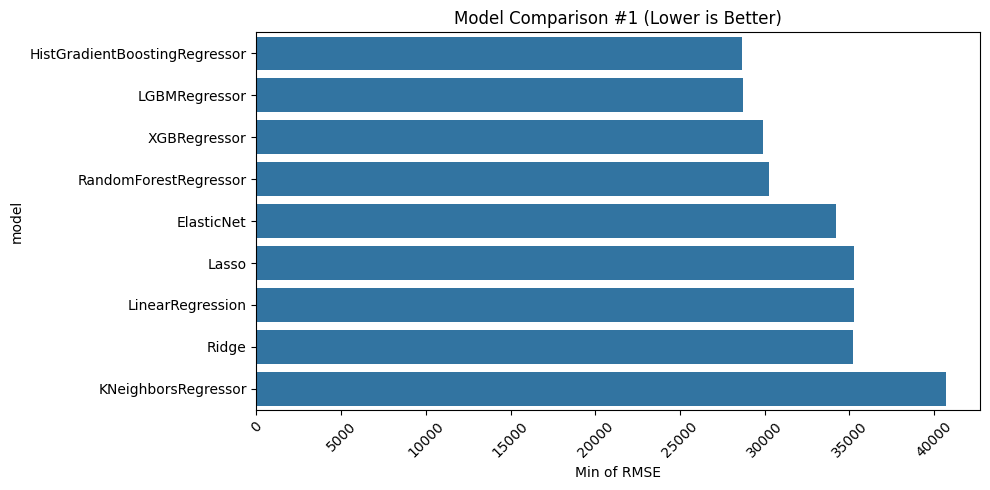

In [179]:
# Plot RMSE Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=res_basic.sort_values('msle1'), y='model', x='rmse', estimator='min', orient='h', errorbar=None)
plt.xticks(rotation=45)
# plt.axvline(x=28713) # checking whether estimator min really works. 
plt.xlabel('Min of RMSE')
plt.title('Model Comparison #1 (Lower is Better)')
plt.tight_layout()
plt.show()

In [185]:
# Predict & evaluate on test set
y_pred = grid_basic.predict(X_te)
rmse = root_mean_squared_error(y_te, y_pred)
msle = root_mean_squared_log_error(y_te, y_pred)
print("Test RMSE:", round(rmse, -3), "\nTest MSLE", round(msle,3)), rmse/163

Test RMSE: 28000.0 
Test MSLE 0.144


(None, 174.78310452497476)

**Insight**
- Feature engineering is useless, even in linear model (?)
- Maybe, because the one I implemented isn't that important, while the other features already have a great effect
- Even a likely important new feature is a useless? whoah, i'm surprised LOL. 
- Anyway, the best 4 are tree models, followed by 4 linear models, and the last one is KN regression
- Elastic net, a linear regression model with L1 & L2 penalty got a pretty good result following the tree models
-  The best model is HGB Regressor, with 0.135 MSLE and 28654 RMSE, so the mean prediction error is around 29k (note that minimum saleprice is ~35k, median saleprice is ~163k) which isn't really good prediction in average (~18% error, based on a median price), let alone for a cheaper house. 


## Hyperparameter Tuning
Ohho, I got another ways to do things. Let's try it here. It's harder to read. Haha, I'm just dead. 


In [37]:
models = {
    'lr': LinearRegression(),
    'rg': Ridge(random_state=42),
    'ls': Lasso(random_state=0),
    'en': ElasticNet(random_state=0),
    'kn': KNeighborsRegressor(),
    'rf': RandomForestRegressor(random_state=42),
    'hg': HistGradientBoostingRegressor(random_state=42),
    'xg': XGBRegressor(random_state=42),
    'lg': LGBMRegressor(random_state=42)
}

In [ ]:
param_grid = [
    {
        'model': [models['lr']]
    },
    {
        'model': [models['rg']],
        'model__alpha': [0.01, 0.1, 1.0]
    },
    {
        'model': [models['ls']],
        'model__alpha': [0.0001, 0.001, 0.01]
    },
    {
        'model': [models['en']],
        'model__alpha': [0.001, 0.01],
        'model__l1_ratio': [0.1, 0.5]
    },
    {
        'model': [models['kn']],
        'model__n_neighbors': [3, 5],
        'model__weights': ['uniform', 'distance']
    },
    {
        'model': [models['rf']],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10],
        'model__min_samples_leaf': [1, 4],
    },
    {
        'model': [models['hg']],
        'model__max_iter': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth':[None, 10]
    },
    {
        'model': [models['xg']],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 6]
    },
    {
        'model': [models['lg']],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__num_leaves': [31, 63]
    },
]


In [137]:
grid = GridSearchCV(
    full_pipe,
    param_grid,
    cv=kf, 
    scoring = {'rmse':'neg_root_mean_squared_error',
               'msle':'neg_root_mean_squared_log_error',
            #    'msle': rmse_log_scorer
            },
    refit = 'msle', verbose=0, n_jobs=-1,
    return_train_score=True
)
grid.fit(X_tr, y_tr)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'model': [LinearRegression()]}, {'model': [Ridge(random_state=42)], 'model__alpha': [0.01, 0.1, ...]}, ...]"
,scoring,"{'msle': 'neg_root_mean_squared_log_error', 'rmse': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'msle'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num', ...), ('ord', ...)]"


In [142]:
# save, can't do with feature_eng, need to be in py or so? 
joblib.dump(grid.best_estimator_, '../models/best_model01.joblib')

['../models/best_model01.joblib']

In [186]:
# Predict & evaluate on test set
y_pred = grid.predict(X_te)
rmse = root_mean_squared_error(y_te, y_pred)
msle = root_mean_squared_log_error(y_te, y_pred)
print("Test RMSE:", round(rmse, -3), "\nTest MSLE", round(msle,3)), rmse/163

Test RMSE: 26000.0 
Test MSLE 0.138


(None, 161.054363976227)

In [ ]:
# oh, there's no longer error. 
res02= pd.DataFrame(grid.cv_results_).sort_values('mean_test_msle', ascending=False)
res02['mean_test_RMSE'] = -res02['mean_test_rmse']
res02['mean_test_MSLE'] = -res02['mean_test_msle']
res02['model'] = res02.param_model.apply(lambda x: type(x).__name__)

# compare models
res02 = res02[['model', 'mean_test_MSLE', 'mean_test_RMSE', 'mean_fit_time', 'param_model','params']]

res02.head(10)

,model,mean_test_MSLE,mean_test_RMSE,mean_fit_time,param_model,params
40,XGBRegressor,0.128424,27196.271484,0.311558,"XGBRegressor(base_score=None, booster=None, ca...","{'model': XGBRegressor(base_score=None, booste..."
39,XGBRegressor,0.131992,27774.520703,0.202700,"XGBRegressor(base_score=None, booster=None, ca...","{'model': XGBRegressor(base_score=None, booste..."
33,HistGradientBoostingRegressor,0.134213,28399.440983,0.633292,HistGradientBoostingRegressor(random_state=42),{'model': HistGradientBoostingRegressor(random...
31,HistGradientBoostingRegressor,0.134947,28654.379248,1.182607,HistGradientBoostingRegressor(random_state=42),{'model': HistGradientBoostingRegressor(random...
34,HistGradientBoostingRegressor,0.135090,29151.475078,1.103731,HistGradientBoostingRegressor(random_state=42),{'model': HistGradientBoostingRegressor(random...
47,LGBMRegressor,0.135486,28713.579960,1.212945,LGBMRegressor(random_state=42),"{'model': LGBMRegressor(random_state=42), 'mod..."
32,HistGradientBoostingRegressor,0.136186,29404.696801,1.612773,HistGradientBoostingRegressor(random_state=42),{'model': HistGradientBoostingRegressor(random...
48,LGBMRegressor,0.136554,28797.246490,1.041351,LGBMRegressor(random_state=42),"{'model': LGBMRegressor(random_state=42), 'mod..."
49,LGBMRegressor,0.136769,29448.196302,1.448680,LGBMRegressor(random_state=42),"{'model': LGBMRegressor(random_state=42), 'mod..."
42,XGBRegressor,0.137192,29184.604687,1.147371,"XGBRegressor(base_score=None, booster=None, ca...","{'model': XGBRegressor(base_score=None, booste..."


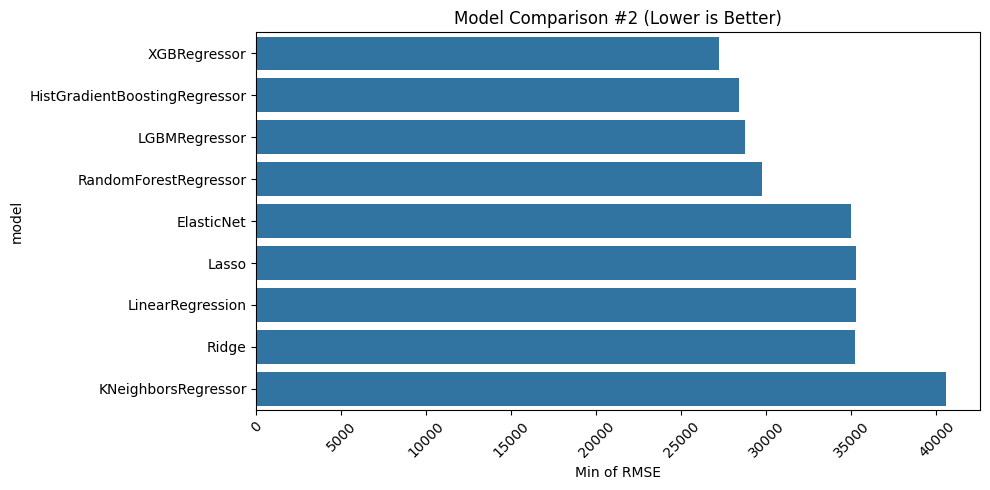

In [ ]:
# Plot RMSE Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=res02, y='model', x='mean_test_RMSE', estimator='min', orient='h', errorbar=None)
plt.xticks(rotation=45)
# plt.axvline(x=28713) # checking whether estimator min really works. 
plt.xlabel('Min of RMSE')
plt.title('Model Comparison #2 (Lower is Better)')
plt.tight_layout()
plt.savefig('../outputs/model_comparison2.png')
plt.show()

In [ ]:
# Save CV results
res02.to_csv("../outputs/model_comparison02.csv", index=False)